In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

# Example-01: Twiss from amplitude data

In [3]:
# In this example twiss beta values are estimated from amplitude data
# Signals are generated using exact model with random noise added on top
# In this case result error is due to the noise alone

# Given the TbT data, the main frequency and correcponding parameters (amplitude and phase) are estimated for x & y planes
# Amplitude data is used to estimate twiss beta values
# Model beta values are used to estimate action at each monitor location
# Total action is estimated using actions from all monitors with optional outlier filtering

In [4]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [5]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883017, sigma_nux=7.04909022e-07, error_nux=8.12403882e-08

(ax - ref_ax).abs().sum().item()=0.000116426351

(fx - ref_fx).abs().sum().item()=0.0350499266



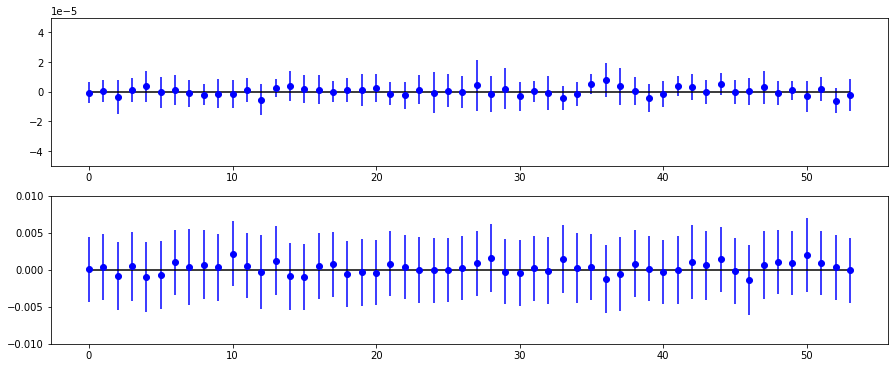

In [6]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774834, sigma_nuy=8.70305271e-07, error_nuy=2.01057779e-07

(ay - ref_ay).abs().sum().item()=0.000108657456

(fy - ref_fy).abs().sum().item()=0.0551002107



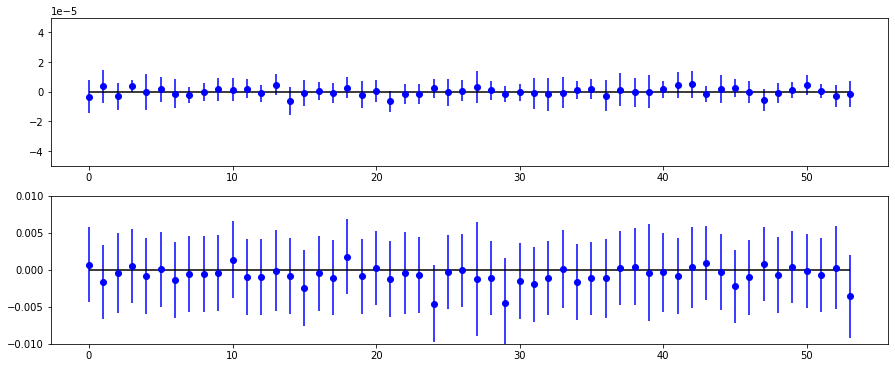

In [7]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

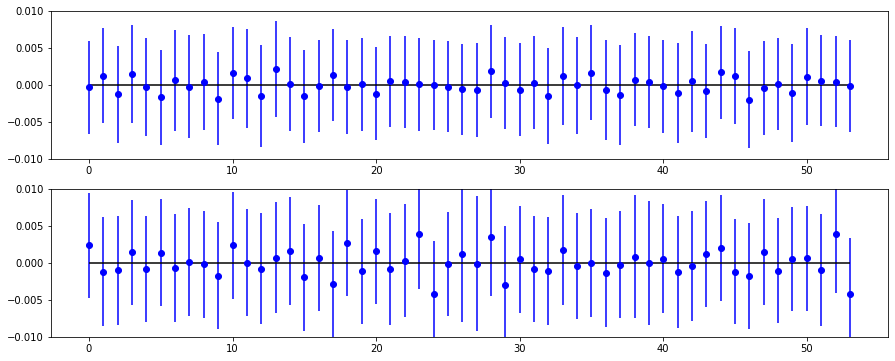

In [8]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [9]:
# Set twiss instance

twiss = Twiss(model, table, use_model=False)

dict_keys(['jx', 'sigma_jx', 'center_jx', 'spread_jx', 'jy', 'sigma_jy', 'center_jy', 'spread_jy', 'mask'])

(abs(ref_jx - center_jx)/ref_jx).item() = 0.000105090676
(abs(ref_jy - center_jy)/ref_jy).item() = 0.000311823793



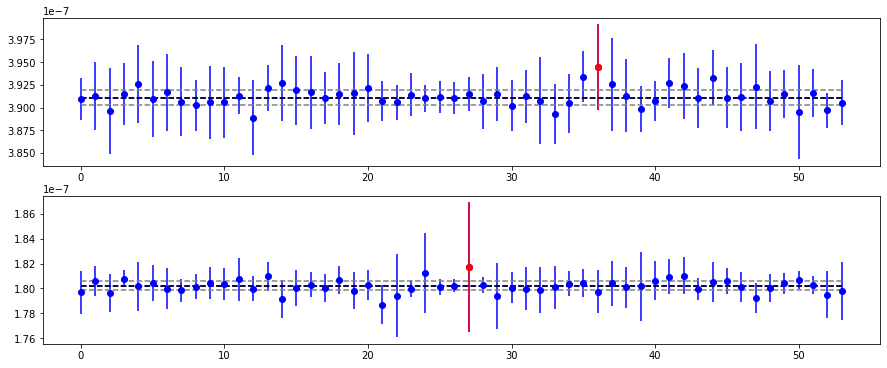

In [10]:
# Estimate action

twiss.get_action(data_threshold={'use': True, 'factor': 3.0})
print(twiss.action.keys())
print()

jx, sigma_jx, center_jx, spread_jx = twiss.action['jx'], twiss.action['sigma_jx'], twiss.action['center_jx'], twiss.action['spread_jx']
jy, sigma_jy, center_jy, spread_jy = twiss.action['jy'], twiss.action['sigma_jy'], twiss.action['center_jy'], twiss.action['spread_jy']

ref_jx = (ref_ax**2/(2.0*model.bx[model.monitor_index])).mean()
ref_jy = (ref_ay**2/(2.0*model.by[model.monitor_index])).mean()

print(f'{(abs(ref_jx - center_jx)/ref_jx).item() = :12.9}')
print(f'{(abs(ref_jy - center_jy)/ref_jy).item() = :12.9}')
print()

mask_x, mask_y = twiss.action['mask'].logical_not()
out_jx, out_jy = torch.arange(model.monitor_count)[mask_x], torch.arange(model.monitor_count)[mask_y]

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), jx.cpu().numpy(), yerr=sigma_jx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(out_jx.cpu().numpy(), jx[out_jx].cpu().numpy(), yerr=sigma_jx[out_jx].cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.hlines([(center_jx - spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([center_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax1.hlines([(center_jx + spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([ref_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')


ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), jy.cpu().numpy(), yerr=sigma_jy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(out_jy.cpu().numpy(), jy[out_jy].cpu().numpy(), yerr=sigma_jy[out_jy].cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.hlines([(center_jy - spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([center_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax2.hlines([(center_jy + spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([ref_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')

plt.show()

dict_keys(['bx', 'sigma_bx', 'by', 'sigma_by'])

(bx - model.bx[model.monitor_index]).abs().sum().item()= 0.728269009
(by - model.by[model.monitor_index]).abs().sum().item()=  1.28712129



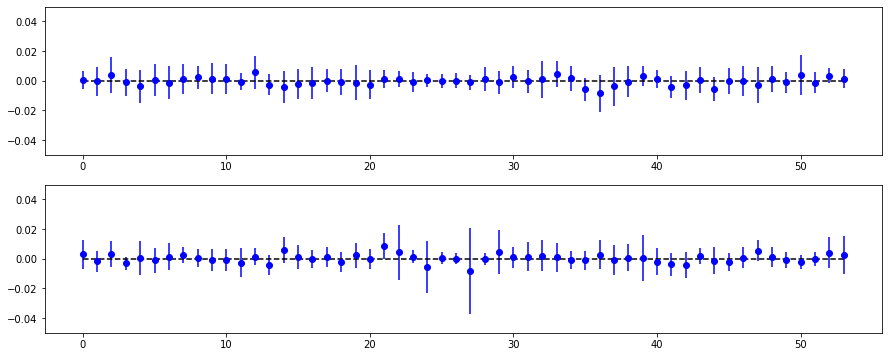

In [11]:
# Estimate twiss beta

twiss.get_twiss_from_amplitude()
print(twiss.data_amplitude.keys())
print()

bx, sigma_bx = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by, sigma_by = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

bx_m = model.bx[model.monitor_index]
by_m = model.by[model.monitor_index]

print(f'{(bx - model.bx[model.monitor_index]).abs().sum().item()=:12.9}')
print(f'{(by - model.by[model.monitor_index]).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), ((bx_m - bx)/bx_m).cpu().numpy(), yerr=(sigma_bx/bx_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax1.set_ylim(-0.05, +0.05)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), ((by_m - by)/by_m).cpu().numpy(), yerr=(sigma_by/by_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax2.set_ylim(-0.05, +0.05)

plt.show()

# Example-02: Virtual phase and phase correction

In [12]:
# TbT data is only avalible at monitor locations
# Phase at other locations of interest (virtual locations) can be estimated using measured phase at monitors and model advance between them
# For each virtual location, monitor locations around it are used to estimate virtual phase
# Given range limit, the corresponding number of monitors are used on each side around the probed virtual location

# Similary, monitor location itself can be treated as a virtual location, i.e. data from other locations can be used to impove estimation at selected probed location
# Strong bias towards model is introduced in this case, i.e. phase correction should be avoided if real lattice is not close to the model
# Phase at the probed monitor is not used, but can be added or compared with measured phase

# In both cases, the range limit is passed to the method

In [13]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [14]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883288, sigma_nux=7.11875071e-07, error_nux=1.89175474e-07

(ax - ref_ax).abs().sum().item()=9.37703786e-05

(fx - ref_fx).abs().sum().item()= 0.044163856



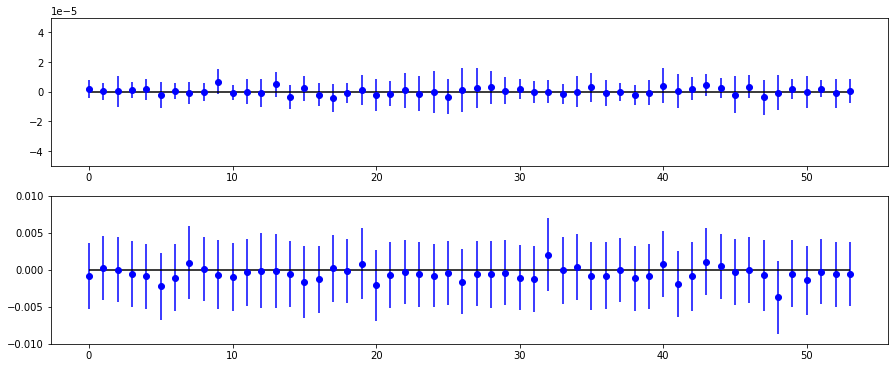

In [15]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy=  0.57677453, sigma_nuy=9.5125323e-07, error_nuy=1.02826559e-07

(ay - ref_ay).abs().sum().item()=0.000104214273

(fy - ref_fy).abs().sum().item()=0.0483930623



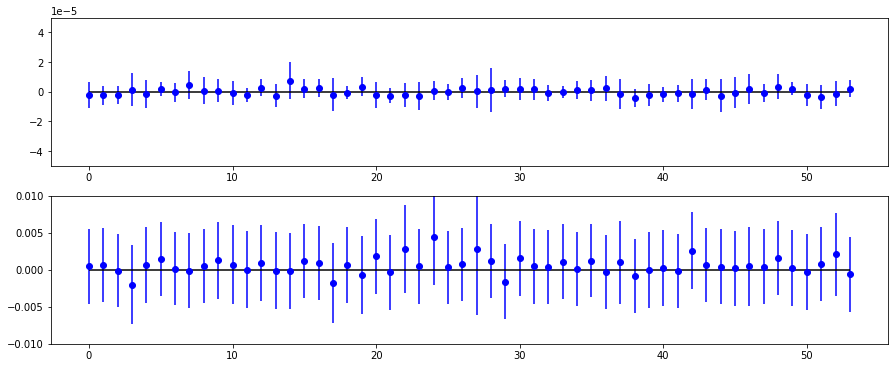

In [16]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

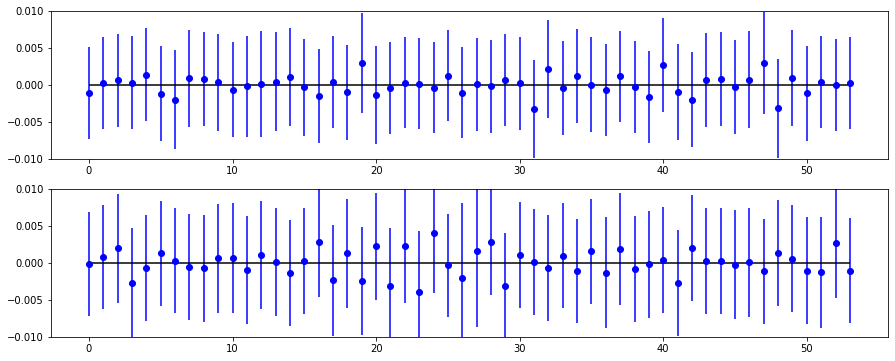

In [17]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [18]:
# Set twiss instance

twiss = Twiss(model, table)

In [19]:
# Print total number of virtual locations and corresponding index
# Note, the first and the last are special virtual locations ('HEAD' and 'TAIL')

print(twiss.model.virtual_count)
print(twiss.model.virtual_index)

# Compute virtual phase at each virtual location
# twiss.fx, twiss.fy and corresponding error are updated (zero at initialization at virtual location indices)
# twiss.correct_x and twiss.correct_y dictionaries with additional information are created or updated
# Note, kwargs can be passed to Decomposition.phase_virtual()

twiss.phase_virtual(limit=8, clean=True, factor=2.0)

5
[0, 2, 28, 54, 58]


dict_keys(['model', 'probe', 'limit', 'index', 'clean', 'phase', 'error'])
tensor([1.019854117005e+00, 4.268490763737e-04], dtype=torch.float64)
28
8
{20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36}
tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])


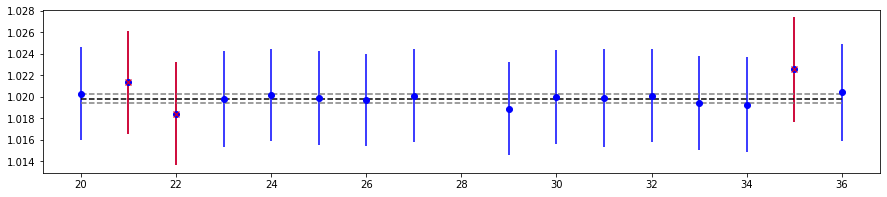

In [20]:
# Examine additional data for a virtual location at IP

_, _, index, *_ = twiss.model.virtual_index

# For each virtual location, addition data dictionary is stored

print(twiss.virtual_x[index].keys())

# Estimated value & error

print(twiss.virtual_x[index]['model'])

# Virtual location index

print(twiss.virtual_x[index]['probe'])

# Range limit

print(twiss.virtual_x[index]['limit'])

# Used locations {index: location}

print(twiss.virtual_x[index]['index'])

# Filter mask

print(twiss.virtual_x[index]['clean'].to(torch.int64))

# Plot phase data and error

keys = torch.tensor([*twiss.virtual_x[index]['index'].keys()], dtype=torch.int64)
mask = twiss.virtual_x[index]['clean'].logical_not()

center, spread = twiss.virtual_x[index]['model'].cpu().numpy()

plt.figure(figsize=(15, 3))
plt.errorbar(keys, twiss.virtual_x[index]['phase'].cpu().numpy(), yerr=twiss.virtual_x[index]['error'].cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(keys[mask], twiss.virtual_x[index]['phase'][mask].cpu().numpy(), yerr=twiss.virtual_x[index]['error'][mask].cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines([center - spread, center, center + spread], min(keys), max(keys), color=['grey', 'black', 'grey'], linestyles='dashed')
plt.show()

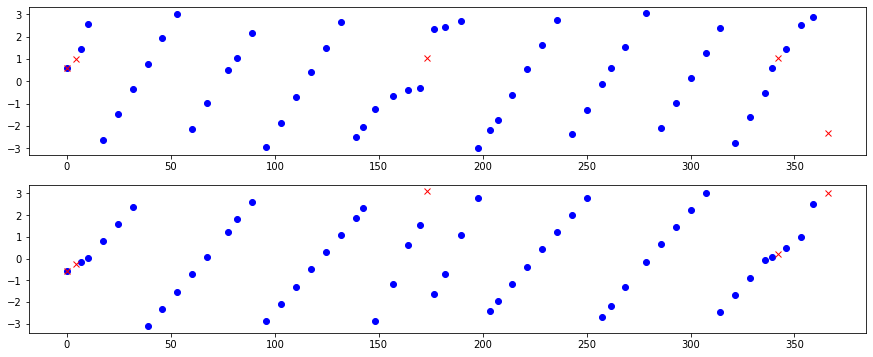

In [21]:
# Plot x & y phase for all locations vs location position

# blue -- monitor locations
# red  -- virtual locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fx[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fy[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fy[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

In [22]:
# Perform phase correction
# Note, kwargs are passed to Decomposition.phase_virtual()

# Similar to virtual phase computation, twiss.correct_x & twiss.correct_y dictionaries are created or updated
# twiss.fx_correct, twiss.fy_correct attributes and corresponding errors are created

twiss.phase_correct(limit=8, clean=True, factor=2.0)

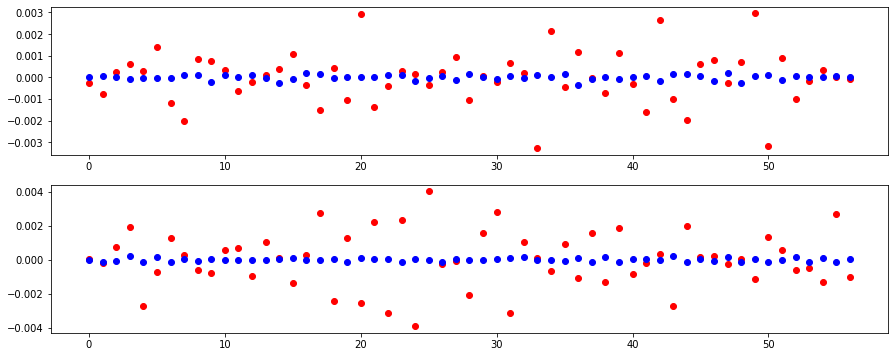

(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=0.0507793034
(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=0.0732457077

(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=0.00515462191
(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=0.00445642816



In [23]:
# Compare adjacent phase advance for uncorrected and corrected case vs model (endpoints are dropped)

# Uncorrected

mux, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx)
muy, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy)

# Corrected

mux_correct, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx_correct)
muy_correct, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy_correct)

# Plot

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux)[1:-1].cpu().numpy(), color='red', marker='o')
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

ax2 = plt.subplot(212)
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy)[1:-1].cpu().numpy(), color='red', marker='o')
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

plt.show()

print(f'{(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-03: Twiss from phase data (adjacent)

In [24]:
# In this example, twiss parameters are computed from phase data using only adjacent monitors, i.e. range limit is one
# Results are compared with model
# Twiss beta values are also compared with twiss from amplitude data computation

In [25]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [26]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883104, sigma_nux=6.41872444e-07, error_nux=5.06214604e-09

(ax - ref_ax).abs().sum().item()=0.000101888221

(fx - ref_fx).abs().sum().item()= 0.029070308



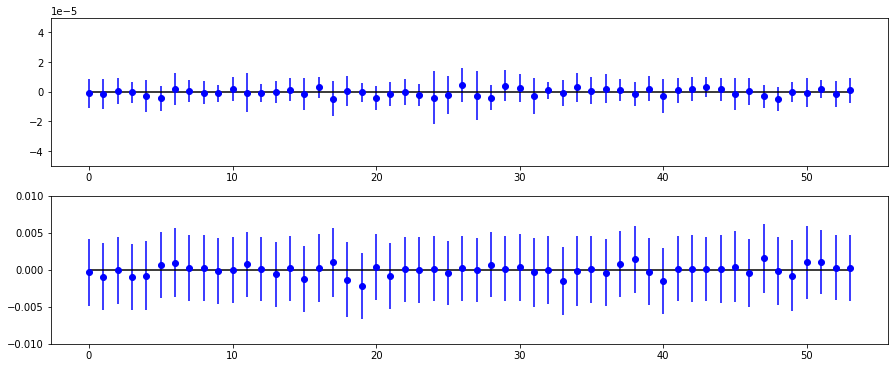

In [27]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy=   0.5767747, sigma_nuy=5.97533576e-07, error_nuy=6.66020683e-08

(ay - ref_ay).abs().sum().item()=0.000113418849

(fy - ref_fy).abs().sum().item()= 0.048120649



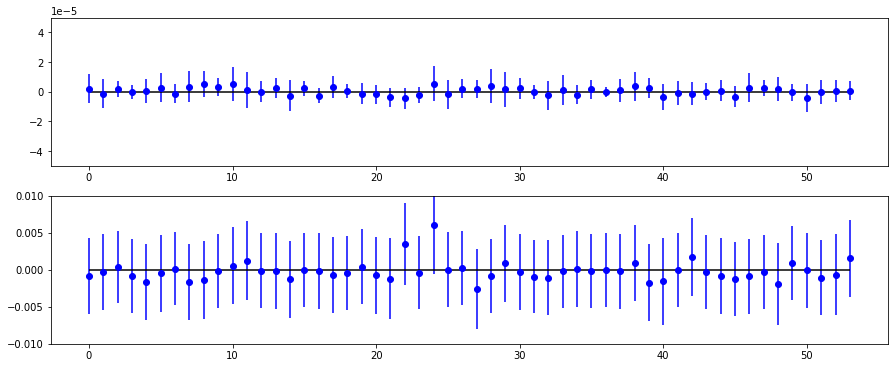

In [28]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

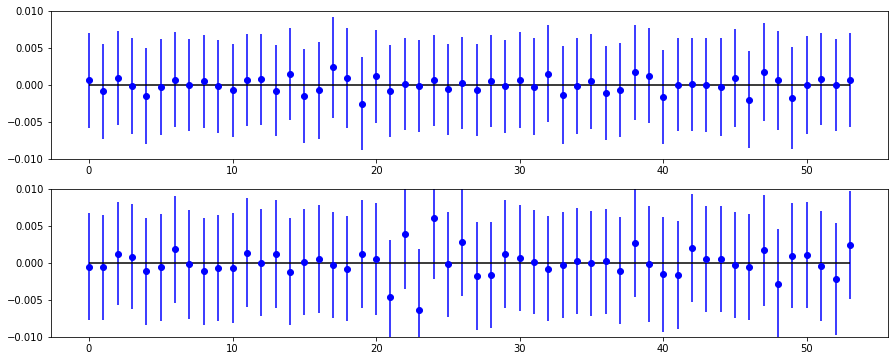

In [29]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [30]:
# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [31]:
# Invocation of get_twiss_from_phase sets twiss.data_phase dictionary
# This dictionary contains model and estimated results for each triplet (phase advance, twiss parameters and corresponding errors)

for key in twiss.data_phase:
    print(key)
    
# i -- probed index, j & k -- other used indices, each combination is given by two pairs (i, j) & (i, k), phase advance is always from i and is negative if i is behind j or k timewise

# fx_ij, fx_m_ij -- estimated and model phase advance for i to j or k for x plane and corresponding errors with 'sigma' prefix
# fy_ij, fy_m_ij -- estimated and model phase advance for i to j or k for y plane and corresponding errors with 'sigma' prefix

# ax, bx -- estimated twiss parameters and corresponding error for x plane and corresponding errors with 'sigma' prefix
# ay, by -- estimated twiss parameters and corresponding error for y plane and corresponding errors with 'sigma' prefix

fx_ij
sigma_fx_ij
fx_m_ij
sigma_fx_m_ij
fx_ik
sigma_fx_ik
fx_m_ik
sigma_fx_m_ik
fy_ij
sigma_fy_ij
fy_m_ij
sigma_fy_m_ij
fy_ik
sigma_fy_ik
fy_m_ik
sigma_fy_m_ik
ax
sigma_ax
bx
sigma_bx
ay
sigma_ay
by
sigma_by


In [32]:
# Since range limit is one here, each location has only one computed value

print(twiss.data_phase['bx'].shape)

torch.Size([59, 1])


In [33]:
# Note, here 'HEAD' virtual location is at the same place as the 1st monitor location
# Phase advance in this case is zero and twiss parameters are not meaningful for 'HEAD' virtual location

print(model.is_same(0, 1))

True


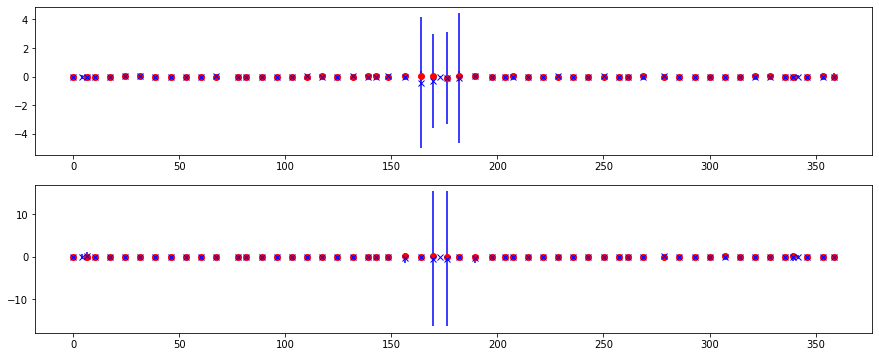

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()= 0.690424926
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.35384917

(bx_m - bx_f)[1:-1].abs().sum().item()=  1.34130341
(by_m - by_f)[1:-1].abs().sum().item()=  2.67814945



In [34]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f)[1:-1].cpu().numpy(), yerr=sigma_bx_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f)[1:-1].cpu().numpy(), yerr=sigma_by_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

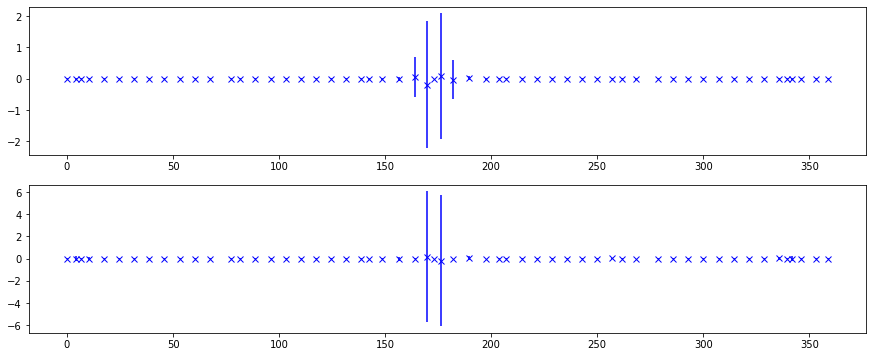

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.443380301
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.643177766



In [35]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

# Twiss from phase

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f)[1:-1].cpu().numpy(), yerr=sigma_ax_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f)[1:-1].cpu().numpy(), yerr=sigma_ay_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-04: Twiss from phase data (range limit & phase correction)

In [36]:
# In this example several combinations (triplets = two diffrent pairs that include probe and two other) are used to estimate twiss parameters for given probed location
# For each combination twiss parameters and corresponding errors are computed
# Data from different combinations can be filtered (remove outlires) and processed (center and spread estimation)

# Twiss parameters are also computed using corrected phase
# Note, phase correction generates strong bias towards the used model
# In this example signals are generated using exact model and this bias is not manifested

In [37]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [38]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883001, sigma_nux=4.82394069e-07, error_nux=9.76392082e-08

(ax - ref_ax).abs().sum().item()=0.000118214609

(fx - ref_fx).abs().sum().item()=0.0327242458



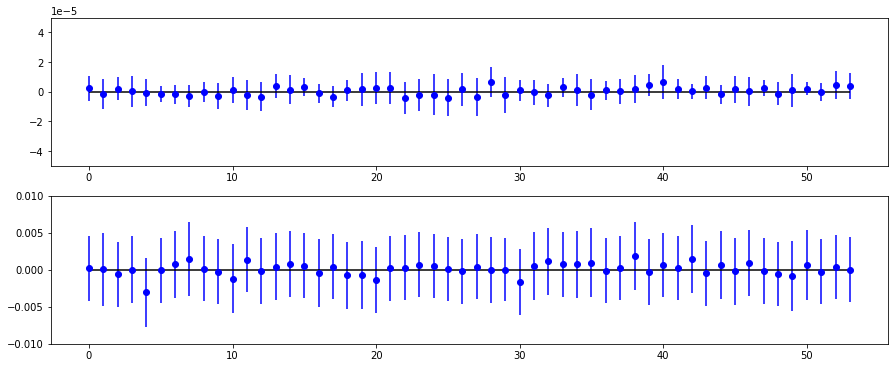

In [39]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774764, sigma_nuy=1.1004261e-06, error_nuy=1.30528576e-07

(ay - ref_ay).abs().sum().item()=0.000110851308

(fy - ref_fy).abs().sum().item()=0.0424593351



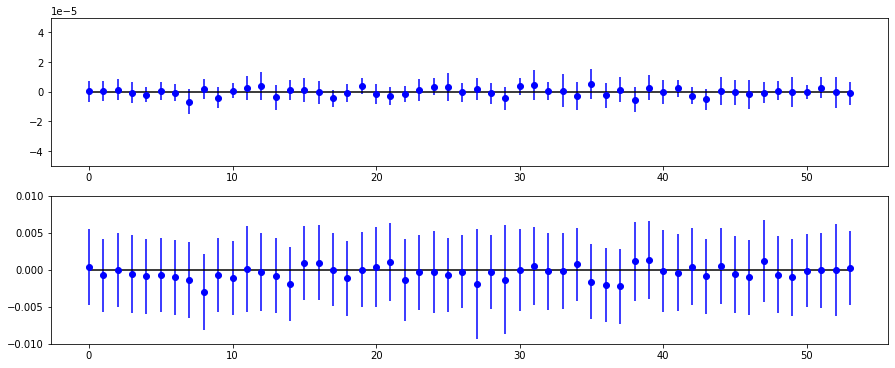

In [40]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

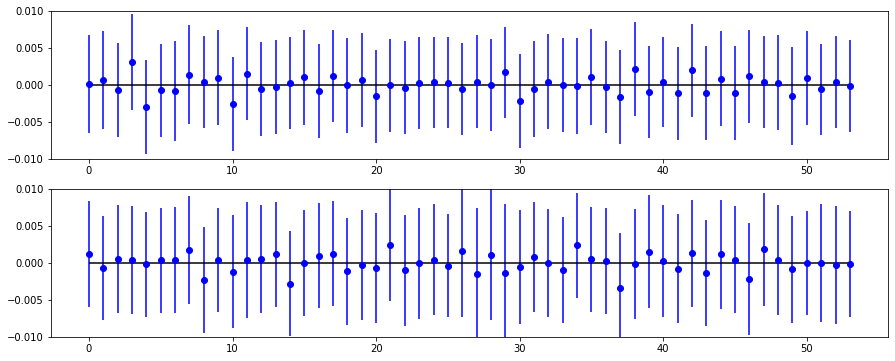

In [41]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [42]:
# Estimate twiss parameters using adjacent monitors
# For each probed location the closest monitor location is used on each side

# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

In [43]:
# Estimate using range of monitors
# Here, for each probed location 8 monitor locations are used on each side

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [44]:
# Note, for given range limit, the number of combinations is limit*(2*limit - 1)

print(max(twiss.limit))
print(max(twiss.limit)*(2*max(twiss.limit) - 1))
print(twiss.data_phase['bx'].shape)

8
120
torch.Size([59, 120])


In [45]:
# Pairs are also generated for each location
# Note, virtual locations do not appear as other indices
# Combinations are also sorted by limit

print(twiss.combo[0].shape)
print(twiss.combo[0, 0].cpu().numpy().tolist())
# [[i, j], [i, k]]

torch.Size([120, 2, 2])
[[0, -2], [0, 1]]


In [46]:
# Data filtering can be performed with filter_twiss method (filtering is performed for x or y plane at a time)
# This method returns a mask with True/False values, True if a combination passes all filtering methods and False otherwise
# This mask can be used as weights, i.e. combinations with False have zero weight

# Several filtering options are avaliable (by default all are used)
# Set 'use' value to True or False

mask_x = twiss.filter_twiss(plane='x',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

mask_y = twiss.filter_twiss(plane='y',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

# phase -- clean based on absolute cotangents value for (i, j) or (i, k) model and measured advance
# model -- clean based on advance proximity to model
# value -- clean based on beta proximity to model
# sigma -- clean based on estimated phase advance error value
# limit -- clean outliers outside interval computed using robust center and spread estimators

print(len(mask_x.flatten()), mask_x.count_nonzero().item())
print(len(mask_y.flatten()), mask_y.count_nonzero().item())

7080 6367
7080 5970


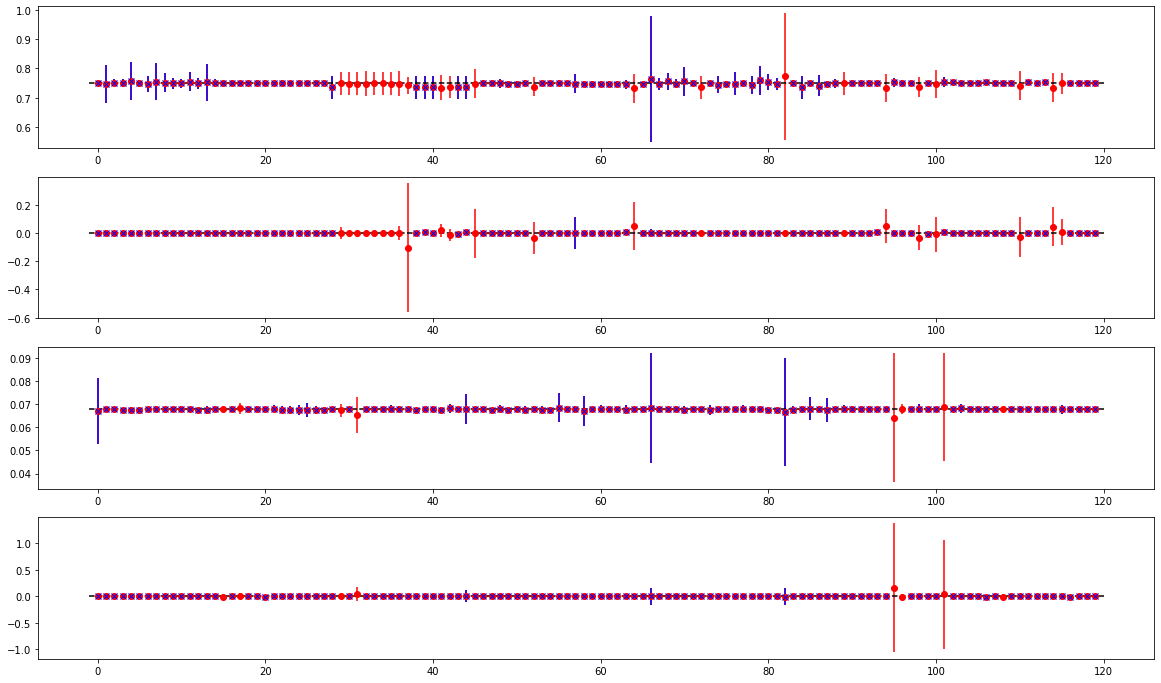

In [47]:
# Plot all combinations (red) and indicate selected (blue) for a selected location
# Note, 'HEAD' and 'TAIL' locations should not be used
# Change probe value

probe = 28

index = torch.arange(max(twiss.limit)*(2*max(twiss.limit) - 1), device=device)

bx, sigma_bx = twiss.data_phase['bx'][probe], twiss.data_phase['sigma_bx'][probe]
ax, sigma_ax = twiss.data_phase['ax'][probe], twiss.data_phase['sigma_ax'][probe]

by, sigma_by = twiss.data_phase['by'][probe], twiss.data_phase['sigma_by'][probe]
ay, sigma_ay = twiss.data_phase['ay'][probe], twiss.data_phase['sigma_ay'][probe]

plt.figure(figsize=(20, 3*4))

# bx
ax1 = plt.subplot(411)
ax1.errorbar(index.cpu().numpy(), bx.cpu().numpy(), yerr=sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
ax1.errorbar(index[mask_x[probe]].cpu().numpy(), bx[mask_x[probe]].cpu().numpy(), yerr=sigma_bx[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax1.hlines(model.bx[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ax
ax2 = plt.subplot(412)
ax2.errorbar(index.cpu().numpy(), ax.cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
ax2.errorbar(index[mask_x[probe]].cpu().numpy(), ax[mask_x[probe]].cpu().numpy(), yerr=sigma_ax[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax2.hlines(model.ax[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# by
ax3 = plt.subplot(413)
ax3.errorbar(index.cpu().numpy(), by.cpu().numpy(), yerr=sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
ax3.errorbar(index[mask_y[probe]].cpu().numpy(), by[mask_y[probe]].cpu().numpy(), yerr=sigma_by[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax3.hlines(model.by[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ay
ax4 = plt.subplot(414)
ax4.errorbar(index.cpu().numpy(), ay.cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
ax4.errorbar(index[mask_y[probe]].cpu().numpy(), ay[mask_y[probe]].cpu().numpy(), yerr=sigma_ay[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax4.hlines(model.ay[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

plt.show()

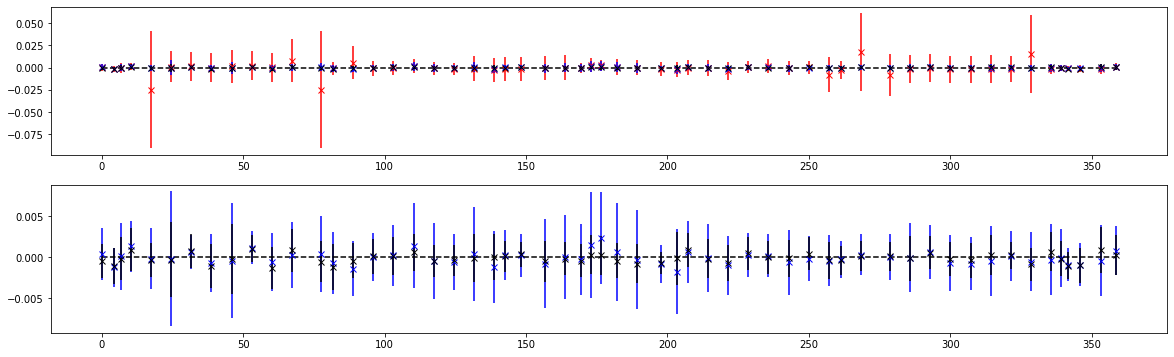

(bx_m - bx_1)[1:-1].abs().sum().item()=  1.36597844
(bx_m - bx_2)[1:-1].abs().sum().item()= 0.339065138
(bx_m - bx_3)[1:-1].abs().sum().item()= 0.244914915



In [48]:
# Twiss data processing can be performed with process_twiss method
# This method returns the result as a dictionary
# dict_keys(['value_a', 'sigma_a', 'error_a', 'value_b', 'sigma_b', 'error_b'])
# And updates self.ax, self.bx, self.ay, self.by and corresponding errors
# Processing is done for one plane ('x' or 'y') at a time

# This method uses weighted estimator for center and spread
# If weight is True, estimated errors for each combinations are used as weights
# If mask is provided, it is used as weights (weight is False) or weights are multiplied by given mask (weight is True)
# Combinations with False values thus have zero weight

# Compare different processing options

# No filtering or weights

out1 = twiss.process_twiss(plane='x', mask=None, weight=False)

# Filter mask is used as weights

out2 = twiss.process_twiss(plane='x', mask=mask_x, weight=False)

# Weights for each combitations are multiplied by filter mask

out3 = twiss.process_twiss(plane='x', mask=mask_x, weight=True)

bx_m = twiss.model.bx

bx_1, sigma_bx_1 = out1['value_b'], out1['sigma_b']
bx_2, sigma_bx_2 = out2['value_b'], out2['sigma_b']
bx_3, sigma_bx_3 = out3['value_b'], out3['sigma_b']

# red - 1, blue - 2, black - 3

plt.figure(figsize=(20, 3*2))

# 1 & 2 & 3
ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_1)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_1/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax1.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

# 2 & 3
ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax2.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

plt.show()

print(f'{(bx_m - bx_1)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_2)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_3)[1:-1].abs().sum().item()=:12.9}')
print()

In [49]:
# Compare different cases of twiss computation

# 1 -- from amplitude
# 2 -- from phase (range limit)
# 3 -- from phase (range limit & correction)

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.phase_correct()

# Uncorrected 

twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_combo, sigma_ax_f_combo = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_combo, sigma_bx_f_combo = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_combo, sigma_ay_f_combo = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_combo, sigma_by_f_combo = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

# Corrected

twiss.get_twiss_from_phase(use_correct=True)
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_correct, sigma_ax_f_correct = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_correct, sigma_bx_f_correct = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_correct, sigma_ay_f_correct = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_correct, sigma_by_f_correct = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()= 0.863273069
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.28610946

(bx_m - bx_f)[1:-1].abs().sum().item()=  1.60385988
(by_m - by_f)[1:-1].abs().sum().item()=  2.85811578

(bx_m - bx_f_combo)[1:-1].abs().sum().item()= 0.244914915
(by_m - by_f_combo)[1:-1].abs().sum().item()= 0.393209296

(bx_m - bx_f_correct)[1:-1].abs().sum().item()=0.0351527048
(by_m - by_f_correct)[1:-1].abs().sum().item()=0.0588696613



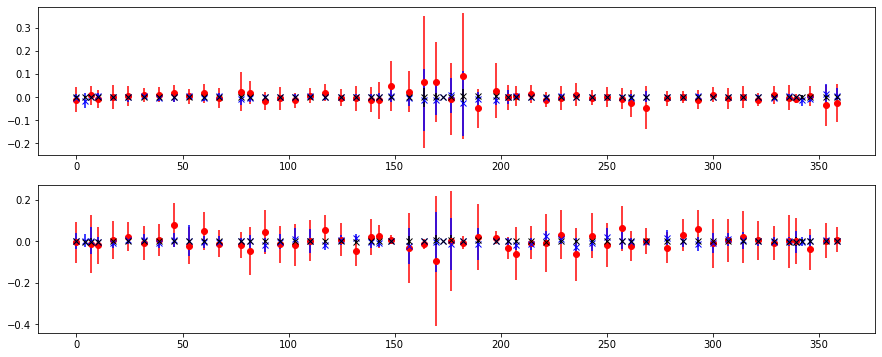

In [50]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_combo)[1:-1].cpu().numpy(), yerr=sigma_bx_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_correct)[1:-1].cpu().numpy(), yerr=sigma_bx_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_combo)[1:-1].cpu().numpy(), yerr=sigma_by_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_correct)[1:-1].cpu().numpy(), yerr=sigma_by_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.508336952
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.829152977

(ax_m - ax_f_combo)[1:-1].abs().sum().item()=0.0854087903
(ay_m - ay_f_combo)[1:-1].abs().sum().item()= 0.105469315

(ax_m - ax_f_correct)[1:-1].abs().sum().item()=0.0115386618
(ay_m - ay_f_correct)[1:-1].abs().sum().item()=0.0181083705



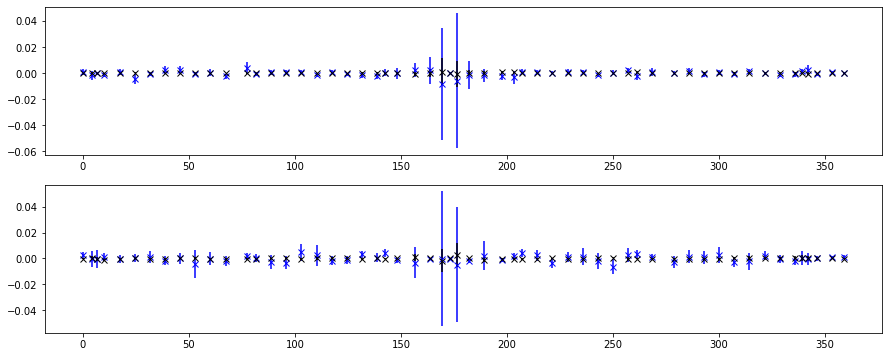

In [51]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ax_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ax_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ay_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ay_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

In [52]:
# Using several combinations can significanty impove twiss estimation accuracy based on phase data
# In this example random noise is the only error source
# Since signals are generated using the model, phase correction improves accuracy significantly in this case

# Example-05: Default twiss (__call__ method)

In [53]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [54]:
# Set noise

noise_x = 1.0E-12*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-12*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [55]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883099, sigma_nux=1.63758838e-10, error_nux=5.56577007e-12

(ax - ref_ax).abs().sum().item()=2.73694728e-06

(fx - ref_fx).abs().sum().item()=0.00148650823



In [56]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774633, sigma_nuy=1.03384642e-10, error_nuy=1.41853196e-12

(ay - ref_ay).abs().sum().item()=4.15588287e-07

(fy - ref_fy).abs().sum().item()=0.00217106796



In [57]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [58]:
# Default twiss (compute action, beta from amplitude, virtual phase, corrected phase and twiss from phase)

twiss = Twiss(model, table, limit=8)
twiss()

,name,kind,flag,time,ax,sigma_ax,bx,sigma_bx,fx,sigma_fx,ay,sigma_ay,by,sigma_by,fy,sigma_fy
0,HEAD,VIRTUAL,0,0.000000,-0.678262,0.000022,7.466915,0.000208,0.596029,0.000032,0.654488,0.000085,15.855507,0.001578,-0.579502,0.000048
1,STP2,MONITOR,1,0.000000,-0.678229,0.000034,7.466905,0.000335,0.596007,0.004324,0.654366,0.000099,15.855699,0.001891,-0.579427,0.004938
2,IV4P,VIRTUAL,0,4.153500,1.954926,0.000093,14.237249,0.000675,0.981890,0.000033,-2.760076,0.000281,13.856804,0.001429,-0.275760,0.000041
3,STP4,MONITOR,1,6.667000,0.382118,0.000025,3.121258,0.000118,1.433601,0.004268,3.092283,0.000317,30.435210,0.003210,-0.172410,0.004919
4,SRP1,MONITOR,1,10.190565,-0.801389,0.000032,4.736088,0.000168,2.561136,0.004336,1.839963,0.000173,13.262108,0.001308,0.002404,0.004916
5,SRP2,MONITOR,1,17.337624,-0.719881,0.000036,4.559949,0.000209,-2.622744,0.004308,1.839524,0.000142,13.281778,0.001038,0.796335,0.004958
6,SRP3,MONITOR,1,24.484683,-0.770078,0.000023,4.484070,0.000124,-1.465758,0.004256,1.846807,0.000169,13.323609,0.001195,1.587951,0.004920
7,SRP4,MONITOR,1,31.631742,-0.788475,0.000017,4.755679,0.000102,-0.353817,0.004307,1.847066,0.000144,13.302862,0.000991,2.378730,0.004944
8,SRP5,MONITOR,1,38.778801,-0.715181,0.000034,4.489988,0.000204,0.756793,0.004350,1.839776,0.000104,13.261812,0.000795,-3.111299,0.004918
9,SRP6,MONITOR,1,45.925860,-0.788986,0.000030,4.552482,0.000168,1.914130,0.004294,1.839829,0.000117,13.283626,0.000885,-2.317472,0.004950


In [59]:
# Get twiss parameter by index/name

print(twiss.get_ax(28))
print(twiss.get_ax('IP'))

tensor([-1.320213145924e-05,  1.397089161867e-05], dtype=torch.float64)
tensor([-1.320213145924e-05,  1.397089161867e-05], dtype=torch.float64)


In [60]:
# Get all twiss parameters by index/name

for key, value in twiss.get_twiss(28).items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()
    
for key, value in twiss.get_twiss('IP').items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()

ax          : -1.32021315e-05
sigma_ax    : 1.39708916e-05
bx          :  0.750277542
sigma_bx    : 4.20071286e-05
fx          :   1.02052274
sigma_fx    : 3.36041777e-05
ay          : 7.66148018e-06
sigma_ay    : 3.29345468e-05
by          : 0.0677142585
sigma_by    : 4.09473888e-06
fy          :   3.09996197
sigma_fy    : 4.77647552e-05

ax          : -1.32021315e-05
sigma_ax    : 1.39708916e-05
bx          :  0.750277542
sigma_bx    : 4.20071286e-05
fx          :   1.02052274
sigma_fx    : 3.36041777e-05
ay          : 7.66148018e-06
sigma_ay    : 3.29345468e-05
by          : 0.0677142585
sigma_by    : 4.09473888e-06
fy          :   3.09996197
sigma_fy    : 4.77647552e-05

